# Homework

1. Train NN model with custom linear architecture on MNIST or on any dataset from Kaggle (image data with resolution not higher than 80x80 pixels - 
[Sign language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist), 
[A-Z Handwritten Alphabet](https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format), etc.)
2. Visualize epoch progress (loss and accuracy curves)
3. Visualize 10 random elements from test set and model results for those elements

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os

In [81]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (128,)),
])

In [82]:
training_data = torchvision.datasets.MNIST('dataset', train=True, download=True, transform=data_transform)
testing_data = torchvision.datasets.MNIST('dataset', train=False, download=True, transform=data_transform)
training_loader = torch.utils.data.DataLoader(training_data, shuffle=True, batch_size=100)
testing_loader = torch.utils.data.DataLoader(testing_data, shuffle=True, batch_size=100)

In [91]:
class HandwrittenClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(27*27*10, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [92]:
my_model = HandwrittenClassifier()

In [93]:
my_optimizer = optim.Adam(my_model.parameters())
my_loss_fn = nn.CrossEntropyLoss()

In [94]:
def train_one_epoch(model, data_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    total_count = 0
    for X_batch, y_batch in data_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        total_count += X_batch.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / total_count

In [95]:
def validate(model, data_loader):
    model.eval()
    accuracy = 0
    total = 0
    for X_batch, y_batch in data_loader:
        y_pred = model(X_batch)
        accuracy += (torch.argmax(y_pred, 1) == y_batch).float().sum()
        total += len(y_batch)
    return accuracy / total

In [96]:
num_epochs = 10
for epoch in range(num_epochs): 
    avg_loss = train_one_epoch(my_model, training_loader, my_optimizer, my_loss_fn)
    accuracy = validate(my_model, testing_loader)
    print(f"Epoch {epoch}: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

Epoch 0: 
 Accuracy: 83.3%, Avg loss: 1.507314 

Epoch 1: 
 Accuracy: 87.7%, Avg loss: 0.520296 

Epoch 2: 
 Accuracy: 89.3%, Avg loss: 0.434539 

Epoch 3: 
 Accuracy: 89.9%, Avg loss: 0.393791 

Epoch 4: 
 Accuracy: 90.4%, Avg loss: 0.366584 

Epoch 5: 
 Accuracy: 91.2%, Avg loss: 0.342107 

Epoch 6: 
 Accuracy: 91.6%, Avg loss: 0.322035 

Epoch 7: 
 Accuracy: 92.0%, Avg loss: 0.305549 

Epoch 8: 
 Accuracy: 92.4%, Avg loss: 0.286658 

Epoch 9: 
 Accuracy: 92.7%, Avg loss: 0.272717 



In [97]:
new_folder = 'new_folder'
os.makedirs(new_folder, exist_ok=True)
torch.save(my_model.state_dict(), os.path.join(new_folder, 'handwritten_model.pth'))

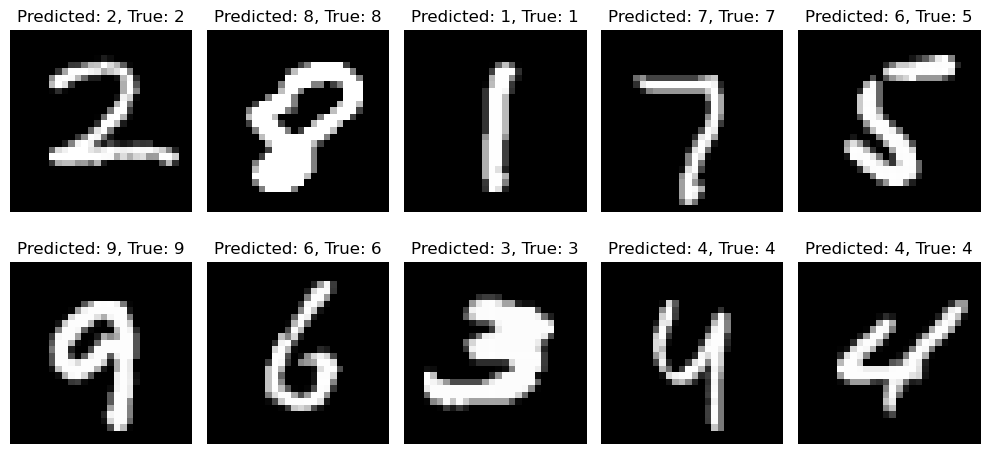

In [103]:
my_model.eval()
dataiter = iter(testing_loader)
images, labels = dataiter.__next__()

idx = np.random.choice(testing_loader.batch_size, 10, replace=False)
images = images[idx]
labels = labels[idx]

outputs = my_model(images)
_, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(f'Predicted: {predicted[i].item()}, True: {labels[i].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()